# Shapely masking Proof of Concept

Problem (As always...): We don't have a clear way of dealing with the cyclic point in longitude. If I recall correctly, even the natural earth shapefiles just use groups of polygons for features that cross the dateline and represent everything.

The code below doesn't solve this yet.

In [1]:
from climate_index_collection.data_loading import load_data_set
from climate_index_collection.reductions import spatial_mask

from matplotlib import pyplot as plt

from shapely.geometry import Polygon, Point, LineString
from shapely.ops import split, unary_union
from shapely.affinity import translate

import numpy as np
import xarray as xr

import geopandas as gpd

ERROR 1: PROJ: proj_create_from_database: Open of /srv/conda/envs/notebook/share/proj failed


In [2]:
ds_FOCI = load_data_set(data_path="../data/test_data/", data_source_name="FOCI")
sst_mean = ds_FOCI["sea-surface-temperature"].mean("time")

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [3]:
NASS_box_lon_lat = Polygon(
    [(-50, 25), (-15, 25), (-15, 50), (-40, 50), (-40, (25+50)//2), (-50, (25+50)//2)]
)

In [4]:
lon_2d, lat_2d = xr.broadcast(ds_FOCI.coords["lon"], ds_FOCI.coords["lat"])
lon_2d = lon_2d % 360 - 360 * ((lon_2d % 360) > 180)

In [5]:
mask = xr.DataArray(
    np.reshape(
        [
            NASS_box_lon_lat.contains(Point(_lon, _lat))
            for _lon, _lat in zip(np.ravel(lon_2d), np.ravel(lat_2d))
        ],
        lon_2d.shape,
    ),
    dims=lon_2d.dims,
    coords=lon_2d.coords,
)

In [6]:
mask.sum()

<xarray.DataArray ()>
array(217)
Coordinates:
    plev     float64 5e+04

In [7]:
NASS_box_lon_lat.contains(Point(-50, 30))

False

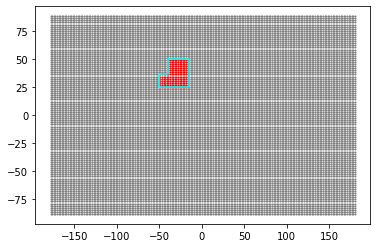

In [8]:
plt.scatter(lon_2d.where(mask), lat_2d.where(mask), s=1, c="r")
plt.scatter(lon_2d.where(~mask), lat_2d.where(~mask), s=1, c="gray")
plt.plot(*NASS_box_lon_lat.exterior.xy, "cyan")

### Getting North Atlantic propely selected
It might make sense to use the area defined by the IPCC
- https://doi.org/10.5194/essd-12-2959-2020
- https://github.com/SantanderMetGroup/ATLAS

https://github.com/SantanderMetGroup/ATLAS/blob/main/reference-regions/IPCC-WGI-reference-regions-v4_shapefile.zip


In [9]:
"""
this all is based on 
https://gis.stackexchange.com/questions/113799/reading-shapefile-in-python
https://gis.stackexchange.com/questions/113799/reading-shapefile-in-python
"""
shapefile = gpd.read_file("IPCC-WGI-reference-regions-v4.shp", SHAPE_RESTORE_SHX = "yes")
NAO_polygon = shapefile["geometry"][50]
EAO_polygon = shapefile["geometry"][51]

In [10]:
mask_NAO = xr.DataArray(
    np.reshape(
        [
            NAO_polygon.contains(Point(_lon, _lat))
            for _lon, _lat in zip(np.ravel(lon_2d), np.ravel(lat_2d))
        ],
        lon_2d.shape,
    ),
    dims=lon_2d.dims,
    coords=lon_2d.coords,
)
mask_EAO = xr.DataArray(
    np.reshape(
        [
            EAO_polygon.contains(Point(_lon, _lat))
            for _lon, _lat in zip(np.ravel(lon_2d), np.ravel(lat_2d))
        ],
        lon_2d.shape,
    ),
    dims=lon_2d.dims,
    coords=lon_2d.coords,
)

mask_Atlantik = (mask_EAO | mask_NAO) & spatial_mask(
    sst_mean,
    lat_north = 70,
    lat_south = 0,
    lon_west = -90,
    lon_east = 15)

prime_meridian = LineString([(0,90), (0,-90)])

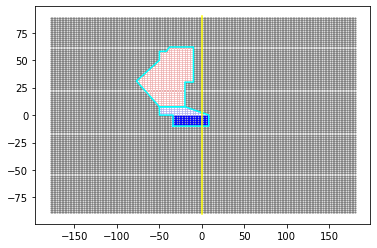

In [11]:
plt.scatter(lon_2d, lat_2d, s=1, c="gray")
plt.scatter(lon_2d.where(mask_NAO), lat_2d.where(mask_NAO), s=1, c="r")
plt.plot(*NAO_polygon.exterior.xy, "cyan")
plt.scatter(lon_2d.where(mask_EAO), lat_2d.where(mask_EAO), s=1, c="b")
plt.plot(*EAO_polygon.exterior.xy, "cyan")
plt.scatter(lon_2d.where(mask_Atlantik), lat_2d.where(mask_Atlantik), s=1, c="w")
plt.plot(*prime_meridian.xy, "yellow")


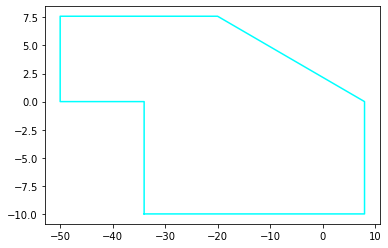

In [12]:
plt.plot(*EAO_polygon.exterior.xy, "cyan")

### Lets try to split these polygons

In [13]:
lon_2d_360, lat_2d_360 = xr.broadcast(ds_FOCI.coords["lon"], ds_FOCI.coords["lat"])

splitted_EAO_polgon = split(EAO_polygon, prime_meridian)
EAO_west = translate(splitted_EAO_polgon.geoms[0], xoff=360)
EAO_east = splitted_EAO_polgon.geoms[1]

mask_EAO_split = xr.DataArray(
    np.reshape(
        [
            EAO_west.contains(Point(_lon, _lat)) |
            EAO_east.contains(Point(_lon, _lat)) 
            for _lon, _lat in zip(np.ravel(lon_2d_360), np.ravel(lat_2d_360))
        ],
        lon_2d_360.shape,
    ),
    dims=lon_2d_360.dims,
    coords=lon_2d_360.coords,
)

In [14]:
len(splitted_EAO_polgon.geoms)

2

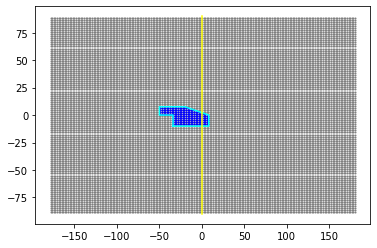

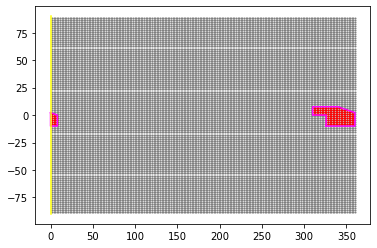

In [15]:

plt.scatter(lon_2d, lat_2d, s=1, c="gray")
plt.scatter(lon_2d.where(mask_EAO), lat_2d.where(mask_EAO), s=1, c="b")
plt.plot(*EAO_polygon.exterior.xy, "cyan")
plt.plot(*prime_meridian.xy, "yellow")
plt.figure()
plt.scatter(lon_2d + 180, lat_2d, s=1, c="gray")
plt.plot(*EAO_west.exterior.xy, "magenta")
plt.plot(*EAO_east.exterior.xy, "magenta")
plt.scatter(lon_2d_360.where(mask_EAO_split), lat_2d_360.where(mask_EAO_split), s=1, c="r")
plt.plot(*prime_meridian.xy, "yellow")


## Using unary_union to make things easier in the mask creation

<class 'shapely.geometry.multipolygon.MultiPolygon'>


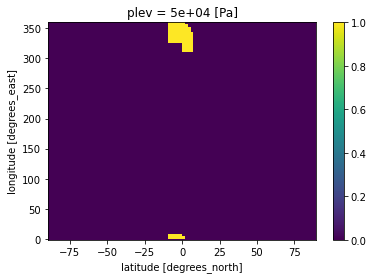

In [16]:
EAO_split = unary_union([EAO_east, EAO_west])
print(type(EAO_split))
mask_EAO_split_union = xr.DataArray(
    np.reshape(
        [
            EAO_split.contains(Point(_lon, _lat))
            for _lon, _lat in zip(np.ravel(lon_2d_360), np.ravel(lat_2d_360))
        ],
        lon_2d_360.shape,
    ),
    dims=lon_2d_360.dims,
    coords=lon_2d_360.coords,
)
mask_EAO_split_union.plot()

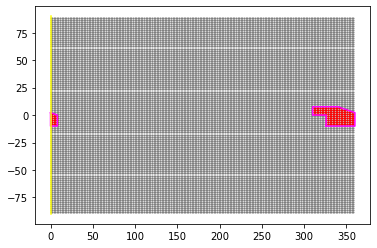

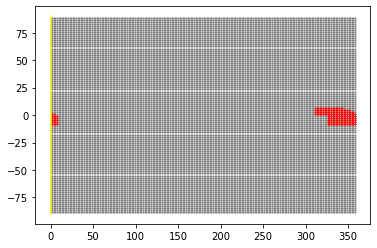

In [17]:
plt.scatter(lon_2d_360, lat_2d_360, s=1, c="gray")
plt.plot(*EAO_west.exterior.xy, "magenta")
plt.plot(*EAO_east.exterior.xy, "magenta")
plt.scatter(lon_2d_360.where(mask_EAO_split), lat_2d_360.where(mask_EAO_split), s=1, c="r")
plt.plot(*prime_meridian.xy, "yellow")

plt.figure()
plt.scatter(lon_2d_360, lat_2d_360, s=1, c="gray")
# plt.plot(*EAO_split.exterior.xy, "magenta")
plt.scatter(lon_2d_360.where(mask_EAO_split_union), lat_2d_360.where(mask_EAO_split_union), s=1, c="r")
plt.plot(*prime_meridian.xy, "yellow")


### Two functions should be enough to support this:

In [37]:
def polygon2mask(dobj, pg, lon_name="lon", lat_name="lat") :
    """
    This funciton creates a mask for a given DataArray or DataSet based on the Polygon or Multipolygon.
    Polygon points are expected be (lon, lat) tuples.
    
    Parameters
    ----------
    dobj: xarray.Dataset or xarray.DataArray
        Contains the original data.
    pg: shaply Polygon or shapely MultiPolygon
        Polygon including the area wanted.

    Returns
    -------
    xarray.Dataset or xarray.DataArray
        Mask for given Polygon on dobj grid.
    """
    
    lon_2d, lat_2d = xr.broadcast(dobj.coords[lon_name], dobj.coords[lat_name])

    mask = xr.DataArray(
        np.reshape(
                [
                    pg.contains(Point(_lon, _lat))
                    for _lon, _lat in zip(np.ravel(lon_2d), np.ravel(lat_2d))
                ],
                lon_2d.shape,
            ),
            dims=lon_2d.dims,
            coords=lon_2d.coords,
        )
    # transpose to have lon on x and lat on y axes
    mask = mask.transpose()
    return mask

    
def polygon_prime_meridian(pg) :
    """
    Transforms polygons defined in [-180W, 180E) coords into [0E,360E) coords.
    Handles polygons crossing the prime meridan.
    Polygon points are expected be (lon, lat) tuples.
    
    Parameters
    ----------
    pg: shaply Polygon or shapely MultiPolygon
        Polygon including the area wanted.

    Returns
    -------
    shapely MultPolygon
        shaply MultiPolygon with single.
    """
    
    # create prime_meridian to eventually split the polygon
    prime_meridian = LineString([(0,90), (0,-90)])
    pg_split = split(pg, prime_meridian)
    pg_list = []
    for temp_pg in pg_split.geoms :
        # check if the poygon minx is less than 0
        if temp_pg.bounds[0] < 0:
            temp_pg = translate(temp_pg, xoff=360)
        pg_list += [temp_pg]
    # create the multipolygon existing in [0E, 360E) coords
    multi_pg = unary_union(pg_list)
    return multi_pg

### The procedure is as follows:
1. Using multiple polygons from shapely and the differenct set theories to create a multiploygon.
2. Pass the multipolygon to polygon_prime_meridian to change coordiante system
3. pass the result from 2. to polygon2mask to create the mask corresponding to the lon, lat grid. 

In [47]:
#1. 
atlantic_big = Polygon([(-90,0), (-90, 70), (20,70), (20, 0)])
pg = unary_union([NAO_polygon, EAO_polygon])
pg = pg.intersection(atlantic_big)
#2. 
atlantic_pg = polygon_prime_meridian(pg)
#3. 
atlantic_mask = polygon2mask(sst_mean, atlantic_pg)

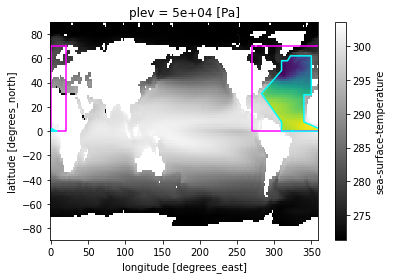

In [48]:
fig, ax = plt.subplots(nrows = 1, ncols = 1)
sst_mean.plot(ax = ax, cmap = "gray")
sst_mean.where(atlantic_mask).plot(ax = ax, add_colorbar=False)

for temp_pg in polygon_prime_meridian(atlantic_big).geoms :
    ax.plot(*temp_pg.exterior.xy, color = "magenta")
for temp_pg in polygon_prime_meridian(atlantic_pg).geoms :
    ax.plot(*temp_pg.exterior.xy, color = "cyan")
    

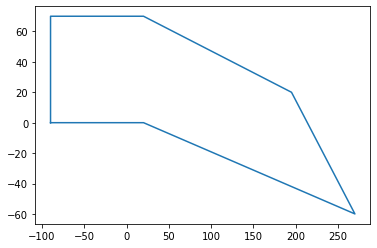

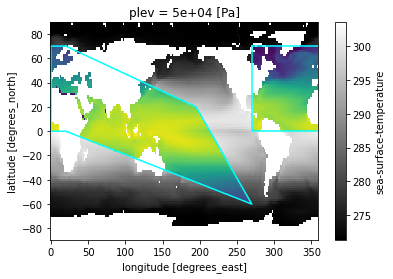

In [45]:
weird_polygon = Polygon([(-90,0), (-90, 70), (20,70), (195, 20), (270, -60), (20, 0)])

plt.plot(*weird_polygon.exterior.xy)
weird_mask = polygon2mask(sst_mean, polygon_prime_meridian(weird_polygon))

fig, ax = plt.subplots(nrows = 1, ncols = 1)
sst_mean.plot(ax = ax, cmap = "gray")
sst_mean.where(weird_mask).plot(ax = ax, add_colorbar=False)

for temp_pg in polygon_prime_meridian(weird_polygon).geoms :
    ax.plot(*temp_pg.exterior.xy, color = "cyan")
    